# Hierarchical is not worth it. Lower AUC

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from catboost import Pool, CatBoostClassifier, cv
pd.options.display.max_columns
pd.set_option('display.max_columns', None)

# Data Prep

In [2]:
X_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/X_train.csv', index_col='id')
y_train = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/train/y_train.csv', squeeze=True)
X_test = pd.read_csv ('https://raw.githubusercontent.com/mkleinbort/Kaggle-COMPAS/main/test/X_test.csv')
y_test = np.full(len(X_test), np.nan)

In [3]:
df = pd.concat([X_train, X_test])

df = df.drop(['v_screening_date'], axis=1) # duplicate of 'screening_date'
df = df.drop(['v_type_of_assessment'], axis=1) # duplicate of 'type_of_assessment'
df = df.drop(['type_of_assessment'], axis=1) # 0 variance

df['target'] = y_train.to_list() + list(y_test) # set target row-wise (ignoring indices)
# df['target'] = 0

In [4]:
# Engineer a new targets 
df['target_int'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 2}) # so we can do regression
df['target_bool'] = df['target'].replace({'No-Recidivism': 0, 'Non-Violent': 1, 'Violent': 1}) # 0 - no-rec, 1 - rec
target_cols = ['target', 'target_int', 'target_bool']

In [5]:
# Engineer new date based features

"""
Custody: when someone is kept in prison until they go to court
Screening:  involves  using  a  brief  instrument  to  quickly  capture basic information 
    about a person’s risk to reoffend and is  used  to  determine  if  a  more  comprehensive  assessment
    is  warranted.  In  a  jail  setting,  everyone,  regardless  of  legal  status, should be screened 
    at booking.  Risk  screening  divides  the  jail  population  into  high-,  medium-,  and  low-risk 
    categories,  making  it  possible  to  direct  intervention  resources  first  to  the highest-risk individuals.



- c_arrest_date and c_offense_date are mutually exclusive and one of them is 99.8% likely to be filled
- c_arrest_date and c_are mutually exclusive
- start is number of days between c_jail_in and c_jail_out, maybe worth engineering total hours/minutes between
- screening_date is always filled
"""



days_cols = []

def days_between(d1, d2):
    try:
        try:
            d1 = datetime.strptime(d1, "%Y-%m-%d")
        except ValueError:
            d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
            
        try:
            d2 = datetime.strptime(d2, "%Y-%m-%d")
        except ValueError:
            d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
#         return abs((d2 - d1).days)
        return (d2 - d1).days
    except TypeError as e:
        return None

# mutually exclusive and one of them is always filled
df['c_bad_date'] = df['c_arrest_date'].fillna(df['c_offense_date']).fillna(df['in_custody']).fillna(df['screening_date'])

# how many days in custody
df['custody_days'] = df.apply(lambda x: days_between(x.out_custody, x.in_custody), axis=1)

# how quickly after going into custody did the person get screened (might indicate something?)
df['in_custody_to_screening_days'] = df.apply(lambda x: days_between(x.in_custody, x.screening_date), axis=1)

# questionable col because it is age related... Also corr=1 with age
df['birth_to_bad_days'] = df.apply(lambda x: days_between(x.date_of_birth, x.c_bad_date), axis=1)

# How many days passed until recitivism occcured. Golden feature!
df['days_until_recitivism'] = df.apply(lambda x: days_between(x.c_jail_out, x.r_jail_in), axis=1)

date_cols = [ 
    'c_arrest_date', 
    'c_offense_date',
    'screening_date', 
    'in_custody', 
    'out_custody', 
    'date_of_birth',
    'c_jail_in',
    'c_jail_out',
    'r_jail_in',
    'r_jail_out',

    # engineered
    'c_bad_date'
]

duration_cols = [
    'days_b_screening_arrest',
    'custody_days',
    'in_custody_to_screening_days',
    'birth_to_bad_days',
    'days_until_recitivism',
]

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,-4.0,1.0,7147,NaN
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,-4.0,1.0,10776,66.0
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,-1.0,1.0,10236,NaN
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN


In [6]:
# All prior counts
df['all_priors'] = df[[
    'juv_fel_count',
    'juv_misd_count', 
    'juv_other_count',
    'priors_count',
]].sum(axis=1)

In [7]:
# Has recidivism occured?
df['has_r_jail_in'] = df['r_jail_in'].notna()
df['has_r_jail_out'] = df['r_jail_out'].notna()

In [8]:
# fill missing values
df['c_charge_desc'] = df['c_charge_desc'].fillna('missing') 

df.head()

,name,first,last,sex,date_of_birth,age,age_group,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,r_jail_in,r_jail_out,screening_date,in_custody,out_custody,start,id,target,target_int,target_bool,c_bad_date,custody_days,in_custody_to_screening_days,birth_to_bad_days,days_until_recitivism,all_priors,has_r_jail_in,has_r_jail_out
2677,nicholas staggewise,nicholas,staggewise,Male,1994-02-28,22,Less than 25,Caucasian,0,0,0,2,-1.0,2013-09-23 09:01:58,2013-09-27 03:54:42,NaN,2013-09-23,F,arrest case no charge,NaN,NaN,2013-09-24,2013-09-23,2013-09-27,3,NaN,No-Recidivism,0.0,0.0,2013-09-23,-4.0,1.0,7147,NaN,2,False,False
548,newton smith,newton,smith,Male,1995-01-28,21,Less than 25,African-American,0,1,0,1,-1.0,2013-06-16 12:36:42,2013-06-16 07:01:42,2013-06-15,NaN,F,Grand Theft in the 3rd Degree,NaN,NaN,2013-06-17,2013-06-16,2013-06-16,0,NaN,Violent,2.0,1.0,2013-06-15,0.0,1.0,6713,NaN,2,False,False
4483,terrance irvin,terrance,irvin,Male,1984-04-10,32,25 - 45,African-American,0,0,0,6,-1.0,2013-10-11 05:38:14,2013-10-15 07:11:17,2013-10-11,NaN,F,Grand Theft in the 3rd Degree,2013-12-21,2014-02-21,2013-10-12,2013-10-11,2013-10-15,3,NaN,Non-Violent,1.0,1.0,2013-10-11,-4.0,1.0,10776,66.0,6,True,True
9476,jaimie peterson,jaimie,peterson,Female,1986-01-02,30,25 - 45,African-American,0,0,0,3,-1.0,2014-01-11 06:56:43,2014-01-12 02:17:00,2014-01-11,NaN,F,Felony Driving While Lic Suspd,NaN,NaN,2014-01-12,2014-01-11,2014-01-12,0,NaN,No-Recidivism,0.0,0.0,2014-01-11,-1.0,1.0,10236,NaN,3,False,False
199,ritesh sukhlall,ritesh,sukhlall,Male,1987-05-12,28,25 - 45,Caucasian,0,0,0,2,NaN,NaN,NaN,NaN,2013-03-21,F,arrest case no charge,NaN,NaN,2013-08-29,NaN,NaN,0,NaN,No-Recidivism,0.0,0.0,2013-03-21,NaN,NaN,9445,NaN,2,False,False


In [9]:
cols = [
#     'name', useless
#     'first', useless
#     'last', useless
#     'sex', # 0 importance + potential bias
#     'date_of_birth', date
#     'age', # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'juv_fel_count',
#     'juv_misd_count', 
#     'juv_other_count',
#     'priors_count', 
    'days_b_screening_arrest', # + AOC, - fairness
#     'c_jail_in', date
#     'c_jail_out',date
#     'c_offense_date', date
#     'c_arrest_date', date
#     'c_charge_degree',  # 0 importance
#     'c_charge_desc',
#     'r_jail_in', date
#     'r_jail_out', date
#     'screening_date', date
#     'in_custody', date
#     'out_custody', date
    'start', # + AOC, + fairness
#     'target', target
#     'target_int', target
#     'target_bool', target
#     'c_bad_date', date
    'custody_days', # + AOC, + fairness
    'in_custody_to_screening_days', # + AOC, + fairness
#     'birth_to_bad_days', # corr=1 with age
#     'has_r_jail_in', + AOC, - fairness
#     'has_r_jail_out', # corr=1 with r_jail_in
    'days_until_recitivism', # golden feature!
    'all_priors', # good
]

cat_cols = [
#     'sex',  # innapropriate bias
#     'age_group', # innapropriate bias
#     'race', # innapropriate bias
#     'c_charge_degree', # 0 importance
#     'c_charge_desc',
]

In [10]:
df[cols].isna().sum()/len(df[cols])

days_b_screening_arrest         0.056504
start                           0.000000
custody_days                    0.044065
in_custody_to_screening_days    0.044065
days_until_recitivism           0.855577
all_priors                      0.000000
dtype: float64

<AxesSubplot:>

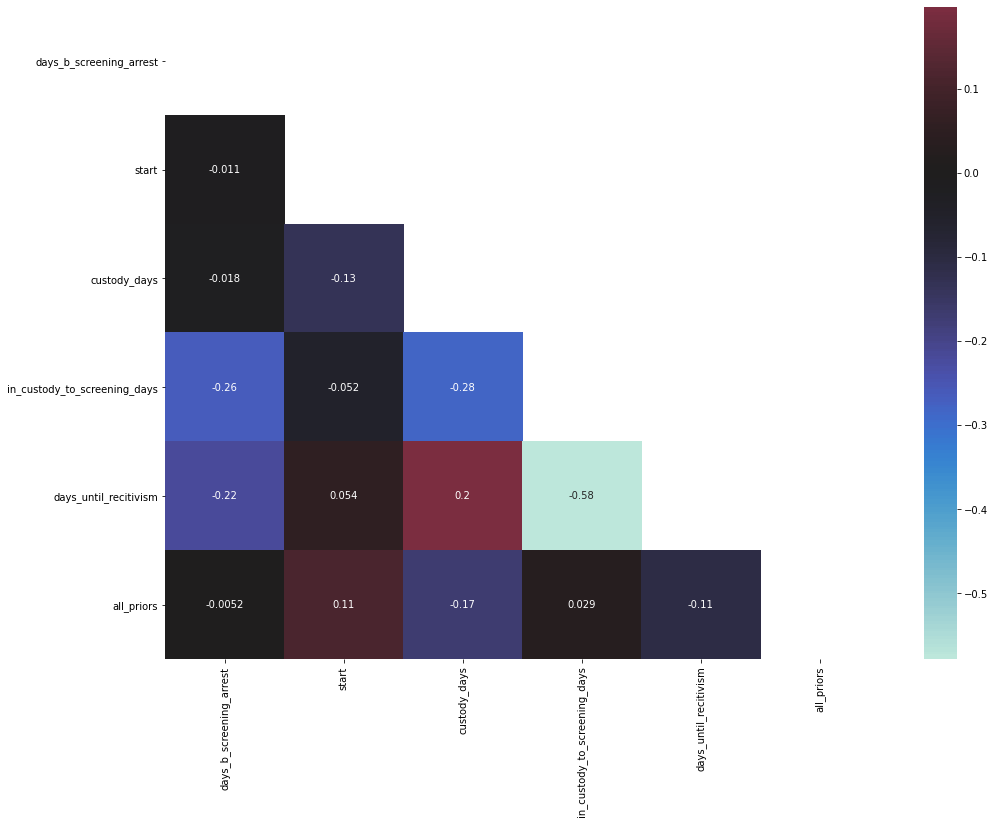

In [11]:
# Numeric correlations across numeric features
f, ax = plt.subplots(figsize=(16, 12))
corr = df[cols].corr()
mask = np.triu(corr)
sns.heatmap(corr.select_dtypes('number'), annot=True, center=0, mask=mask)

In [12]:
df[cols].head()

,days_b_screening_arrest,start,custody_days,in_custody_to_screening_days,days_until_recitivism,all_priors
2677,-1.0,3,-4.0,1.0,NaN,2
548,-1.0,0,0.0,1.0,NaN,2
4483,-1.0,3,-4.0,1.0,66.0,6
9476,-1.0,0,-1.0,1.0,NaN,3
199,NaN,0,NaN,NaN,NaN,2


In [13]:
# df['race'] = df['race'].replace({'Native American': 'Other'})
# df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other'})
df['race'] = df['race'].replace({'Native American': 'Other', 'Asian': 'Other', 'Hispanic': 'Other'})
df['race'].value_counts()

African-American    2266
Caucasian           1701
Other                776
Name: race, dtype: int64

In [14]:
races = df.race.unique()
sexes = df.sex.unique()
age_groups = df.age_group.unique()

# Cross Validation

In [15]:
df[cols] = df[cols].fillna(0)

In [16]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

def fairness_score(y_true, y_pred, sensitive_features):
    mf = MetricFrame(roc_auc_score, y_true, y_pred, sensitive_features=sensitive_features)
    return (1 - np.sqrt(np.std(mf.by_group)))

In [17]:
df_train = df[df.target.notna()]

df_test = df[df.target.isna()]

# Multi-class Classification
Non-recidivism / Non-Violent / Violent

In [18]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df.iloc[train].reset_index(drop=True)
    df_eval_cv = df.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='MultiClass')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
#     preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

Split  1: ROC-AUC: 90.26%. Fairness: R: 79.74%, S: 78.98%, A: 80.62%
Split  2: ROC-AUC: 86.39%. Fairness: R: 85.16%, S: 97.37%, A: 77.76%
Split  3: ROC-AUC: 89.24%. Fairness: R: 78.87%, S: 90.25%, A: 81.82%
Split  4: ROC-AUC: 89.04%. Fairness: R: 77.24%, S: 91.16%, A: 83.62%
Split  5: ROC-AUC: 87.01%. Fairness: R: 82.16%, S: 86.84%, A: 73.68%
Split  6: ROC-AUC: 87.79%. Fairness: R: 86.93%, S: 82.74%, A: 88.06%
Split  7: ROC-AUC: 89.06%. Fairness: R: 81.63%, S: 90.17%, A: 88.80%
Split  8: ROC-AUC: 86.40%. Fairness: R: 89.69%, S: 83.17%, A: 86.05%
Split  9: ROC-AUC: 91.71%. Fairness: R: 88.40%, S: 77.98%, A: 77.55%
Split 10: ROC-AUC: 89.51%. Fairness: R: 78.13%, S: 86.78%, A: 77.71%
Split 11: ROC-AUC: 85.78%. Fairness: R: 82.40%, S: 93.11%, A: 78.30%
Split 12: ROC-AUC: 87.44%. Fairness: R: 75.73%, S: 76.86%, A: 76.76%
Split 13: ROC-AUC: 91.56%. Fairness: R: 84.58%, S: 85.44%, A: 86.01%
Split 14: ROC-AUC: 89.80%. Fairness: R: 79.22%, S: 82.60%, A: 83.10%
Split 15: ROC-AUC: 90.75%. Fairnes

In [19]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

ROC-AUC 88.40% (STD: 2.04%)
Race fairness: 83.72% (STD: 4.80%)
Sex fairness: 83.98% (STD: 5.36%)
Age fairness: 83.02% (STD: 4.88%)


# Hierarchical Classification

### Level 1: Non-recidivism / Recidivism

In [20]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target_bool'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df_train.iloc[train].reset_index(drop=True)
    df_eval_cv = df_train.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
#     preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

Split  1: ROC-AUC: 89.92%. Fairness: R: 83.28%, S: 84.85%, A: 84.31%
Split  2: ROC-AUC: 91.74%. Fairness: R: 83.65%, S: 79.04%, A: 95.50%
Split  3: ROC-AUC: 94.20%. Fairness: R: 80.36%, S: 91.55%, A: 86.29%
Split  4: ROC-AUC: 90.14%. Fairness: R: 81.60%, S: 84.97%, A: 82.57%
Split  5: ROC-AUC: 89.87%. Fairness: R: 76.51%, S: 97.58%, A: 83.96%
Split  6: ROC-AUC: 90.58%. Fairness: R: 85.59%, S: 88.26%, A: 87.82%
Split  7: ROC-AUC: 90.03%. Fairness: R: 93.54%, S: 77.16%, A: 75.00%
Split  8: ROC-AUC: 93.05%. Fairness: R: 80.39%, S: 86.72%, A: 84.17%
Split  9: ROC-AUC: 93.11%. Fairness: R: 88.38%, S: 83.82%, A: 82.25%
Split 10: ROC-AUC: 92.45%. Fairness: R: 83.64%, S: 81.73%, A: 85.88%
Split 11: ROC-AUC: 90.61%. Fairness: R: 75.49%, S: 86.12%, A: 87.30%
Split 12: ROC-AUC: 94.06%. Fairness: R: 85.85%, S: 85.22%, A: 83.95%
Split 13: ROC-AUC: 89.79%. Fairness: R: 84.30%, S: 78.02%, A: 83.82%
Split 14: ROC-AUC: 93.52%. Fairness: R: 86.55%, S: 92.11%, A: 88.75%
Split 15: ROC-AUC: 89.90%. Fairnes

In [21]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

ROC-AUC 91.52% (STD: 1.59%)
Race fairness: 84.62% (STD: 4.66%)
Sex fairness: 86.67% (STD: 4.95%)
Age fairness: 86.24% (STD: 4.54%)


,feature,importance,std,min,max
4,days_until_recitivism,63.130844,5.633203,53.603086,72.409367
5,all_priors,12.089036,2.972364,7.139296,21.392888
3,in_custody_to_screening_days,10.855901,2.143297,5.621803,16.254514
1,start,5.630997,1.371185,2.865042,8.273764
2,custody_days,5.464261,1.678214,2.812969,9.449689
0,days_b_screening_arrest,2.828961,0.941387,1.034123,4.964618


<AxesSubplot:ylabel='feature'>

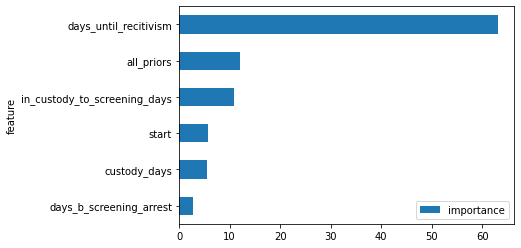

In [22]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))

### Level 2 (Violent vs Non-Violent)

In [27]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train_recid[TARGET_COL].astype('str') + df_train_recid['race'] + df_train_recid['sex'] + df_train_recid['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train_recid[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df_train_recid.iloc[train].reset_index(drop=True)
    df_eval_cv = df_train_recid.iloc[test].reset_index(drop=True)
    
    train_dataset = Pool(data=df_train_cv[cols],
                         label=df_train_cv[TARGET_COL],
                         cat_features=cat_cols)

    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv[TARGET_COL],
                        cat_features=cat_cols)
    
    y_eval = pd.get_dummies(df_eval_cv[TARGET_COL]).to_numpy()
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    # Fit model
    model.fit(train_dataset, verbose=False)
    # Get predicted classes
#     preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')
    
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/target/target_converter.cpp:380: Target with classes must contain only 2 unique values for binary classification

In [ ]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

In [ ]:
# Feature importances
fi_df = pd.DataFrame({'feature': cols})
fi_df['importance'] = np.mean(feature_importances, axis=0)
fi_df['std'] = np.std(feature_importances, axis=0)
fi_df['min'] = np.min(feature_importances, axis=0)
fi_df['max'] = np.max(feature_importances, axis=0)
fi_df = fi_df.sort_values('importance', ascending=False)
display(fi_df)
display(fi_df[['feature', 'importance']].sort_values('importance', ascending=True).plot.barh(x='feature'))

### Both levels (L1+L2)

In [ ]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], strat_df['name'])): # Stratified on race
    df_train_cv = df_train.iloc[train].reset_index(drop=True)
    df_train_cv_recid = df_train_cv[df_train_cv['target'] != 'No-Recidivism']
    df_eval_cv = df_train.iloc[test].reset_index(drop=True)
    
    train_dataset_l1 = Pool(data=df_train_cv[cols],
                         label=df_train_cv['target_bool'],
                         cat_features=cat_cols)
    
    train_dataset_l2 = Pool(data=df_train_cv_recid[cols],
                         label=df_train_cv_recid['target'],
                         cat_features=cat_cols)
    
    eval_dataset = Pool(data=df_eval_cv[cols],
                        label=df_eval_cv['target'],
                        cat_features=cat_cols)
    

    y_eval = pd.get_dummies(df_eval_cv['target']).to_numpy()
    # Initialize CatBoostClassifier
    model_l1 = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    
    model_l2 = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss')
    # Fit model
    model_l1.fit(train_dataset_l1, verbose=False)
    model_l2.fit(train_dataset_l2, verbose=False)
    
    # Get predicted classes
    preds_class_l1 = model_l1.predict(eval_dataset)
    preds_class_l2 = model_l2.predict(eval_dataset)
#     # Get predicted probabilities for each class
    preds_proba_l1 = model_l1.predict_proba(eval_dataset)
    preds_proba_l2 = model_l2.predict_proba(eval_dataset)
    
    preds_class = [(l2 if l1 == 1 else 'No-Recidivism') for l1, l2 in zip(preds_class_l1, preds_class_l2)]
    preds_proba = [(l1[0], l1[1]*l2[0], l1[1]*l2[1]) for l1, l2 in zip(preds_proba_l1, preds_proba_l2)]
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=df_eval_cv['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
        
    roc_aucs.append(roc_auc)
    feature_importances.append(model.get_feature_importance())
    # avg_precs.append(avg_prec)
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

In [ ]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

## Fairlearn GridSearch
Non-recidivism / Recidivism

In [ ]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from fairlearn.reductions import GridSearch, EqualizedOdds

TARGET_COL = 'target_bool'

N_SPLITS = 5
N_REPEATS = 10

# Stratify based on intersections of race, age_group, sex and target.
strat_df = pd.DataFrame(df_train[TARGET_COL].astype('str') + df_train['race'] + df_train['sex'] + df_train['age_group'], columns=['name'])

# If cross section is too small for stratification to work (N < N_SPLITS) we mark it as an outlier
strat_df.loc[strat_df.groupby('name').name.transform('count').lt(N_SPLITS), 'name'] = 'Outliers'    

kf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42)

roc_aucs = []
rms = []
sms = []
ams = []

# feature_importances = []
for split_idx, (train, test) in enumerate(kf.split(df_train[cols], df['race'])): # Stratified on race
    df_train_cv = df_train.iloc[train].reset_index(drop=True)
    eval_df = df_train.iloc[test].reset_index(drop=True)
    
#     y_eval = pd.get_dummies(eval_df[TARGET_COL]).to_numpy()
    y_eval = eval_df[TARGET_COL]
    
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=100,
                               learning_rate=1,
                               depth=2,
                               loss_function='Logloss', 
                               logging_level='Silent')
    
    sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=64,
                   grid_limit=3)
    
    sweep.fit(df_train_cv[cols], df_train_cv[TARGET_COL], sensitive_features=df_train_cv['race'])

    sweep_pred_probas = [predictor.predict_proba(eval_df[cols])[:, 1] for predictor in sweep.predictors_]
#     sweep_preds = [predictor.predict(eval_df[cols]) for predictor in sweep.predictors_] 
    sweep_fairnesses = [
        fairness_score(eval_df[TARGET_COL], preds, sensitive_features=eval_df['race'])
        for preds in sweep_pred_probas
    ]
    sweep_aucs = [
        roc_auc_score(eval_df[TARGET_COL], preds)
        for preds in sweep_pred_probas
    ]

    all_results = pd.DataFrame({"predictor": sweep.predictors_, "fairness": sweep_fairnesses, "auc": sweep_aucs}) 
    all_results['score'] = (all_results['fairness'] + all_results['auc']) / 2
    all_results = all_results.sort_values('score', ascending=False)
    top_models_idx = all_results.iloc[:5].index
    top_sweep_pred_probas = [probs for idx, probs in enumerate(sweep_pred_probas) if idx in top_models_idx]
    preds_proba = np.mean(top_sweep_pred_probas, axis=0)
    
    display(all_results.sort_values('score', ascending=False))

    #     Fit model
#     model.fit(X=df_train_cv[cols], y=df_train_cv[TARGET_COL], cat_features=cat_cols, verbose=0)
    # Get predicted classes
#     preds_class = model.predict(eval_df[cols])
#     # Get predicted probabilities for each class
#     preds_proba = model.predict_proba(eval_df[cols])
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_df[cols], 
#                               prediction_type='RawFormulaVal')
    
    roc_auc = roc_auc_score(y_eval, preds_proba, multi_class="ovo")
    rm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=eval_df['race'])
    sm = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=eval_df['sex'])
    am = MetricFrame(roc_auc_score, y_eval, preds_proba, sensitive_features=eval_df['age_group'])
    
    roc_aucs.append(roc_auc)
    rms.append(rm)
    sms.append(sm)
    ams.append(am)
            
    roc_aucs.append(roc_auc)
#     feature_importances.append(model.get_feature_importance())
    race_fairness = 1 - np.sqrt(np.std(rm.by_group))
    sex_fairness = 1 - np.sqrt(np.std(sm.by_group))
    age_fairness = 1 - np.sqrt(np.std(am.by_group))
    print(f'Split {split_idx+1:2}: ROC-AUC: {roc_auc*100:.2f}%. '
          f'Fairness: R: {race_fairness*100:.2f}%, S: {sex_fairness*100:.2f}%, A: {age_fairness*100:.2f}%')

In [ ]:
# Evaluation

race_fairnesses = [(1 - np.sqrt(np.std(rm.by_group))) for rm in rms]
sex_fairnesses = [(1 - np.sqrt(np.std(sm.by_group))) for sm in sms]
age_fairnesses = [(1 - np.sqrt(np.std(am.by_group))) for am in ams]

print(f'ROC-AUC {np.mean(roc_aucs)*100:.2f}% (STD: {np.std(roc_aucs)*100:.2f}%)') # 90.48
print(f'Race fairness: {np.mean(race_fairnesses)*100:.2f}% (STD: {np.std(race_fairnesses)*100:.2f}%)') # 83.92
print(f'Sex fairness: {np.mean(sex_fairnesses)*100:.2f}% (STD: {np.std(sex_fairnesses)*100:.2f}%)')
print(f'Age fairness: {np.mean(age_fairnesses)*100:.2f}% (STD: {np.std(age_fairnesses)*100:.2f}%)')

In [ ]:
race_auc_df = pd.DataFrame({'race': races, 'auc': rm.by_group})
sex_auc_df = pd.DataFrame({'sex': sexes, 'auc': sm.by_group})
age_auc_df = pd.DataFrame({'age': age_groups, 'auc': am.by_group})
                     
display(race_auc_df[race_auc_df['auc'].notna()].plot.barh(x='race'))
display(sex_auc_df[sex_auc_df['auc'].notna()].plot.barh(x='sex'))
display(age_auc_df[age_auc_df['auc'].notna()].plot.barh(x='age'))

# Full model

In [ ]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import collections
from fairlearn.metrics import MetricFrame

TARGET_COL = 'target'

train_dataset = Pool(data=df_train[cols],
                     label=df_train[TARGET_COL],
                     cat_features=cat_cols)

# eval_dataset = Pool(data=eval_df[cols],
#                     label=eval_df[TARGET_COL],
#                     cat_features=cat_cols)

# y_eval = pd.get_dummies(eval_df[TARGET_COL]).to_numpy()
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass')
# Fit model
model.fit(train_dataset, verbose=True)
# Get predicted classes
preds_class = model.predict(eval_dataset)
#     # Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)
#     # Get predicted RawFormulaVal
#     preds_raw = model.predict(eval_dataset, 
#                               prediction_type='RawFormulaVal')

feature_importances.append(model.get_feature_importance())